<a href="https://colab.research.google.com/github/Sol-J/study-repository/blob/master/question-answering-with-haystack/QA_haystack_%EC%A7%84%EC%86%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question Answering with Haystack**

교과목명 : 자연어처리의 응용

발표자 : 경영학과 진솔 (2021-28722)

---


> #### References
>
> *   Haystack: Neural Question Answering at Scale [Docs](https://haystack.deepset.ai/docs/latest/intromd) [Github](https://github.com/deepset-ai/haystack)
> *   Haystack: Question Answering at Scale [Post](https://medium.com/deepset-ai/haystack-question-answering-at-scale-c2c980e7c657)
> *   How to Build an Open-Domain Question Answering System? [Post](https://lilianweng.github.io/lil-log/2020/10/29/open-domain-question-answering.html)
> *   Basic QA Pipeline Tutorial [Colab](https://colab.research.google.com/github/deepset-ai/haystack/blob/master/tutorials/Tutorial1_Basic_QA_Pipeline.ipynb)
>
> #### Contents
>
> 1. Open Domain Question Answering (ODQA)
> 2. Overview of the QA frameworks
> 3. Example of QA pipeline


## **1. Open Domain Question Answering (ODQA)**

Open Domain Question Answering (ODQA) is a type of language tasks, asking a model to produce answers to factoid questions in natural language.



#### **Main difference between Search and QA system**
- Web Search: Finding document list that contain an answer -> Information Retrieval
- Question Answering: Finding an answer in a paragraph or a document -> Machine Reading Comprehension

#### **Types of questions**

- Factoid type questions (what, which, when, who, how)
- List type quesiton (list of facts or answers)
- Confirmation questions (yes or no)
- Casual question (why, how)
- Hypothetical questions (no specific answers)
- Complex questions

[A. Chandra Obula Reddy. and Dr. K. Madhavi. (2017). A Survey on Types of Question Answering System](http://www.iosrjournals.org/iosr-jce/papers/Vol19-issue6/Version-4/D1906041923.pdf)

####**MRC Dataset (factoid type questions)**
- Stanford Question Answering Dataset (SQuAD) [Link](https://rajpurkar.github.io/SQuAD-explorer/) 
- The Korean Question Answering Dataset (KorQuAD) [Link](https://korquad.github.io/)
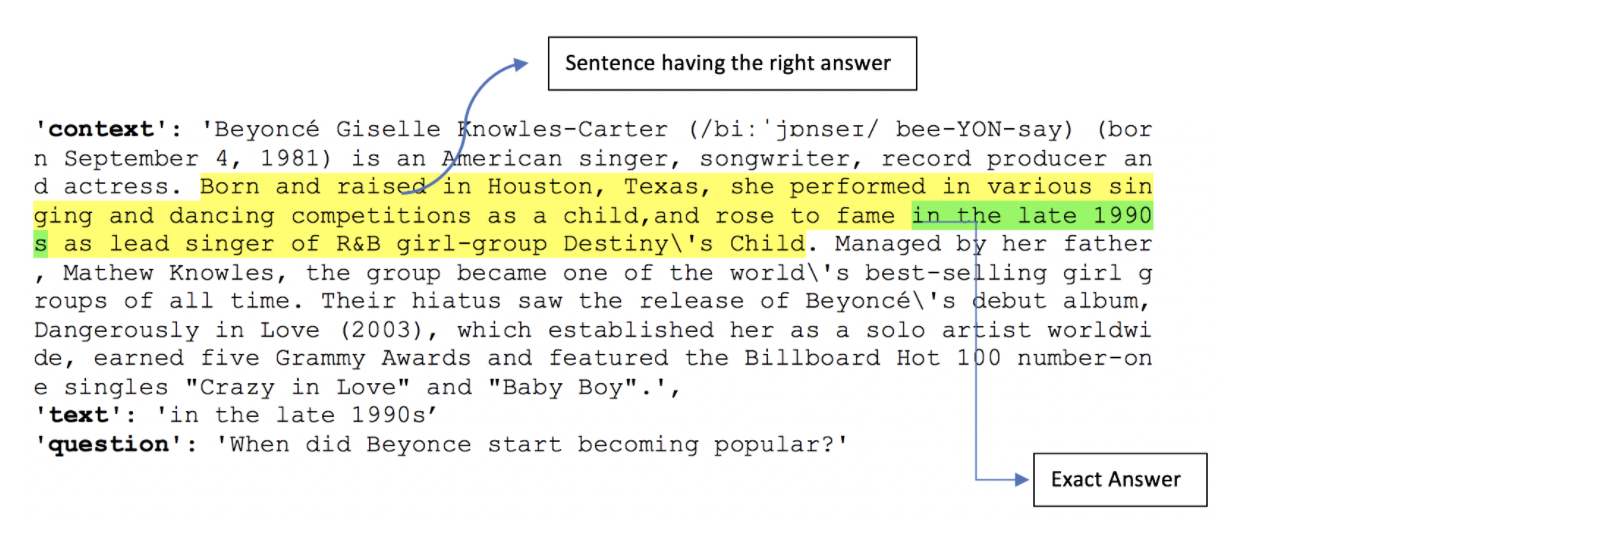
[Source](https://towardsdatascience.com/building-a-question-answering-system-part-1-9388aadff507)

## **2. Overview of the QA frameworks**

* Retriever-Reader (Open-book QA)
* Retriever-Generator (Open-book QA)
* Generator (Closed-book QA)

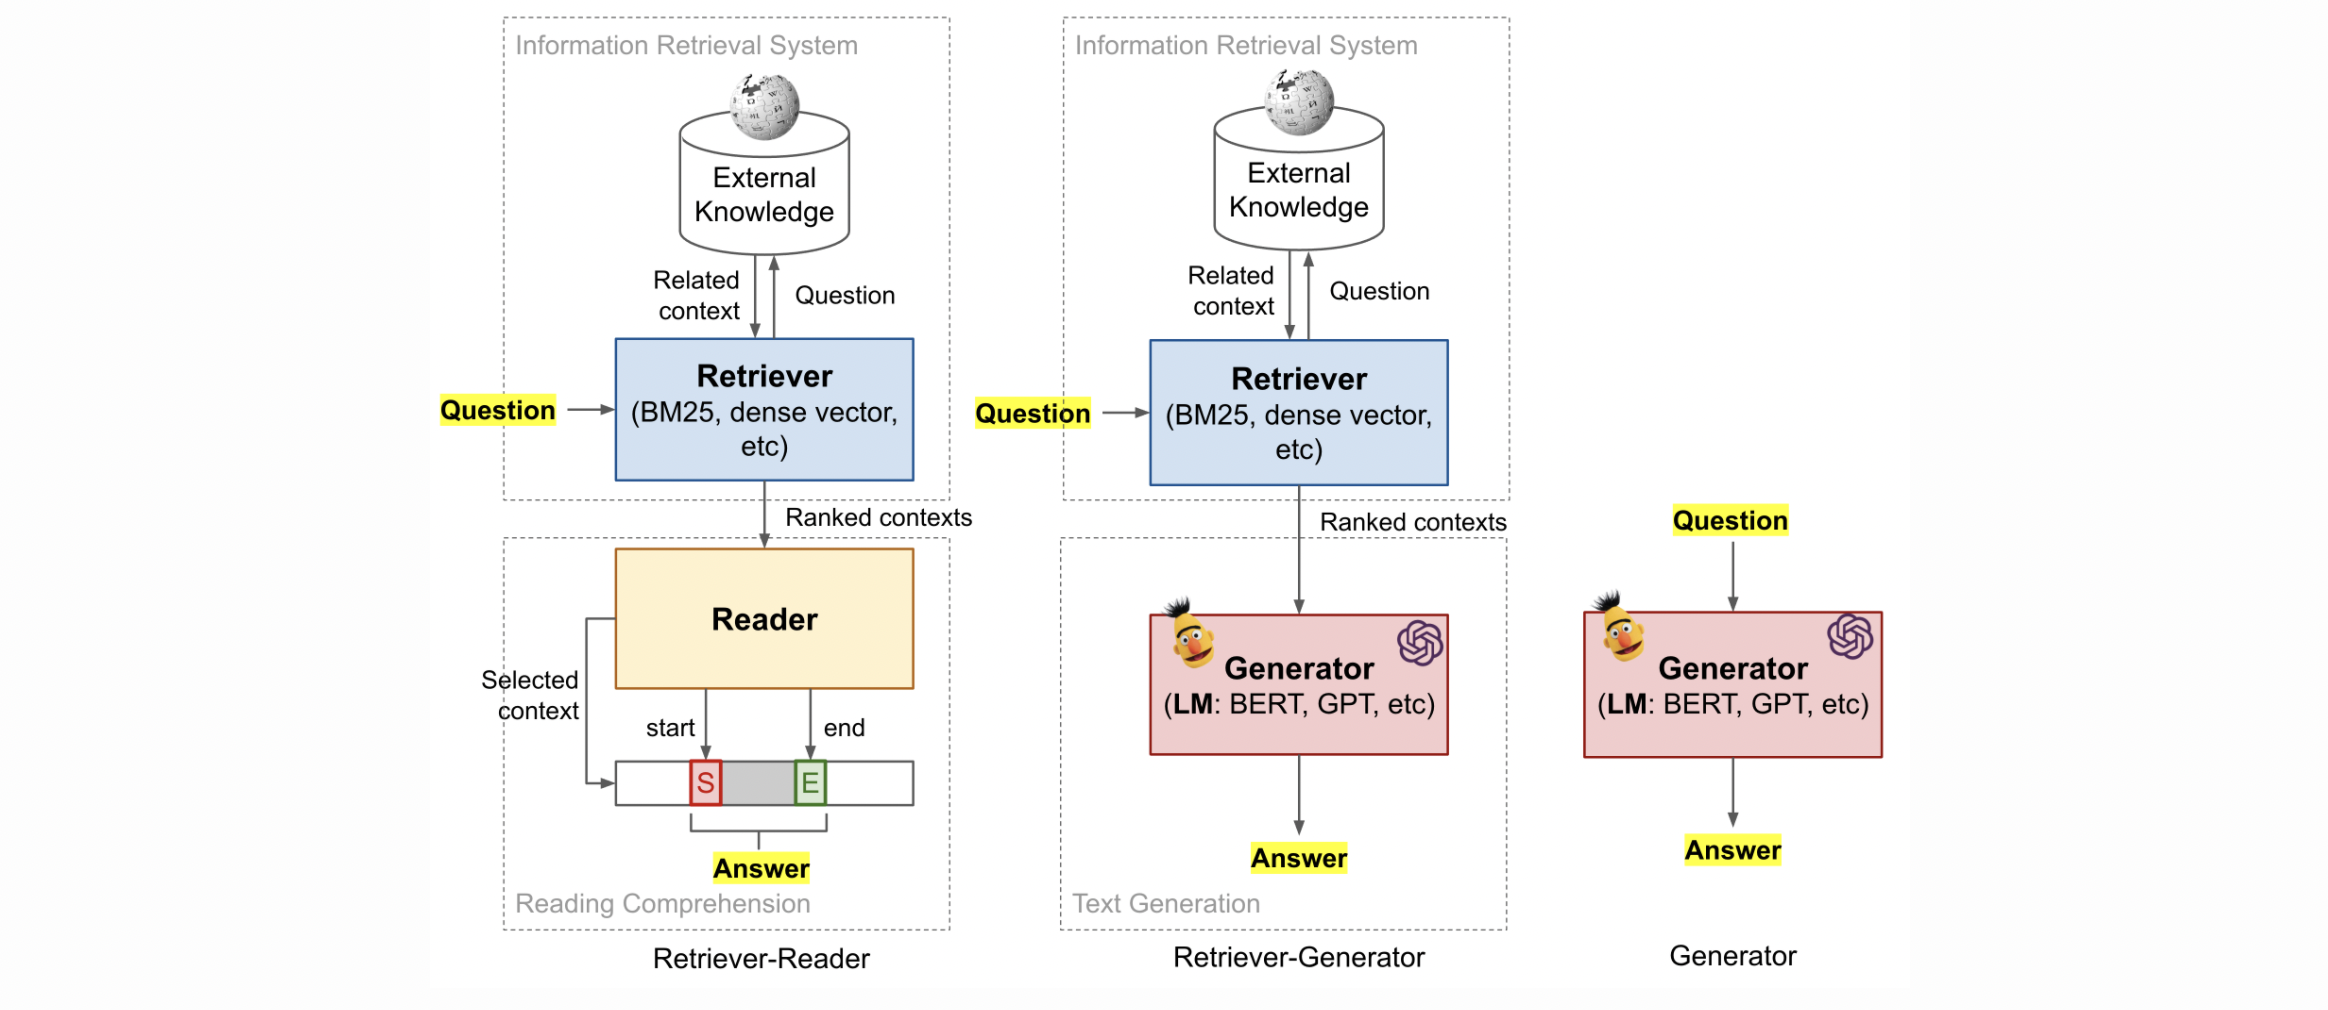

The most common system built with Haystack is the Retriever-Reader Pipeline which is designed to optimize for both speed and performance on the task of Open Domain Question Answering.  The ODQA task combines the challenges of document retrieval (finding the relevant articles) with that of machine comprehension of text (identifying the answer span from those articles). 

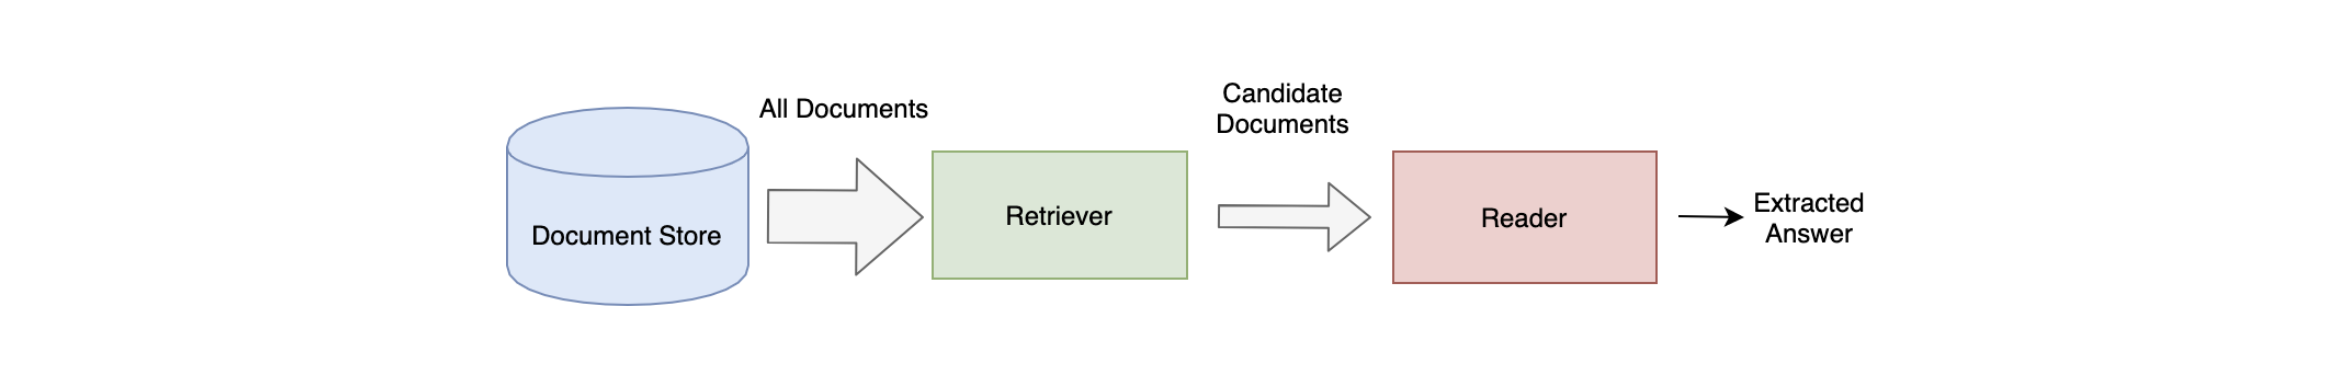

The **Reader** is the component that performs the closest analysis of the text, with great attention to syntactic and semantic detail, in order to find the span that best satisfies the question or query. 

When performing queries in an open domain setting, search can be significantly sped up by first dismissing documents which have no chance of being relevant. This is done through a light-weight document filter known as a **Retriever** which takes all documents as input and returns just as a subset for the Reader to further process. 

## **3. Build a QA pipeline using Haystack**

Ask questions in natural language and find granular answers in documents.

- Install haytack
- Setting up Document Store
- Preprocessing of documents
- Retriever
- Reader
- Pipeline (default)
- Pipeline (multiple retriever)

### **Install haystack**

In [ ]:
# Make sure you have a GPU running
!nvidia-smi

Tue Apr 27 13:51:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install the latest master of Haystack
!pip install git+https://github.com/deepset-ai/haystack.git

      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1


### **Setting up Document Store**

You can think of the DocumentStore as a "database" that:

* stores your texts and meta data
* provides them to the retriever at query time

Haystack finds answers to queries within the documents stored in a `DocumentStore`. There are different DocumentStores in Haystack to fit different use cases and tech stacks. The current implementations of `DocumentStore` include `ElasticsearchDocumentStore`, `FAISSDocumentStore`,  `SQLDocumentStore`, and `InMemoryDocumentStore`. [More](https://haystack.deepset.ai/docs/latest/documentstoremd)

You can configure Haystack to work with your existing document stores.







In [ ]:
# Start an Elasticsearch server
# You can start Elasticsearch on your local machine instance using Docker. 
# If Docker is not readily available in your environment (eg., in Colab notebooks), then you can manually download and execute Elasticsearch from source.
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )

# wait until ES has started
! sleep 30

In [ ]:
# Connect to Elasticsearch
# Fast & accurate sparse retrieval with many tuning options
# Basic support for dense retrieval

from haystack.document_store import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore()

04/27/2021 13:55:51 - INFO - faiss.loader -   Loading faiss with AVX2 support.
04/27/2021 13:55:51 - INFO - faiss.loader -   Loading faiss.
04/27/2021 13:55:52 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
04/27/2021 13:55:54 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.102s]
04/27/2021 13:55:54 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.427s]
04/27/2021 13:55:55 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.252s]


In [ ]:
'''
# Connect to FAISS
## Fast & accurate dense retrieval
### No efficient sparse retrieval

from haystack.document_store import FAISSDocumentStore
document_store = FAISSDocumentStore(similarity="dot_product")
'''

### **Preprocessing of documents**

Haystack provides a customizable pipeline for:
 - converting files into texts
 - cleaning texts
 - splitting texts
 - writing them to a Document Store

Data Source: https://terms.naver.com/list.naver?cid=50871&categoryId=50871


In [ ]:
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http

# Let's first fetch some documents that we want to query
# Here: 102 Encyclopedia contexts for disease

doc_dir = "data/health_txt"
s3_url = "https://raw.githubusercontent.com/Sol-J/study-repository/master/data/health_txt_1.zip"

fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Fetching from https://raw.githubusercontent.com/Sol-J/study-repository/master/data/health_txt_1.zip to `data/health_txt`
100%|██████████| 481924/481924 [00:00<00:00, 10282248.19B/s]
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/097. 헬리코박터 균.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/017. 꽃가루알레르기.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/011. 골반염.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/007. 결핵.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/064. 위궤양.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/014. 구내염.txt
04/27/2021 13:55:55 - INFO - haystack.preprocessor.utils -   Converting data/health_txt/041. 봉와직염.txt
04/27/2021 13:55:55 - INFO - haystack.prep

In [ ]:
# Let's have a look at the second entries:
print(dicts[1])

{'text': '꽃가루알레르기란 알레르기 체질인 사람이 원인 물질인 작은 꽃가루를 코나 기도 등을 통해 들이마실 때 발생하는 알레르기성 호흡기 질환을 말한다. 꽃가루는 수꽃술의 가루로 눈에 보이지 않는 작은 물질로 대게 풍매화로 인하여 꽃가루알레르기 증상이 발생한다. 이 경우, 알레르기를 일으키는 원인 물질(항원)이 꽃가루이며, 항원이 코 점막에 노출된 후 자극 부위로 비만세포, 호산구를 비롯한 여러 종류의 IgE 항체를 매개로 하는 염증세포가 몰려들어 이들이 분비하는 다양한 매개물질에 의하여 염증반응이 발생한다.\n연속적으로 일어나는 발작적인 재채기, 맑은 콧물, 코 막힘, 가려움증의 네 가지 주요 증상을 특징으로 한다. 특징적인 증상 외에도 눈 주위 가려움, 눈 충혈, 두통, 후각 감퇴 등의 증상이 동반될 수 있으며 합병증으로 결막염, 중이염, 부비동염, 인후두염 등이 동반될 수 있다.\n꽃가루 알레르기의 주된 원인은 누런 먼지처럼 공중에 날아다니는 삼나무, 오리나무, 자작나무 등의 꽃가루이다.\n꽃가루 알레르기의 대표적인 증상은 알레르기성 비염, 결막염, 피부염, 기관지 천식이다. 특히 꽃가루로 인하여 알레르기성 비염이 발생하면 물 같은 콧물이 지속되고, 연속적으로 재채기를 하며, 양쪽 콧구멍이 번갈아 막힌다. 또한 알레르기성 결막염이 생기면 눈이 심하게 가려워져서 눈을 비비게 되며, 증세가 심한 경우 눈이 충혈되거나 눈곱이 끼기도 한다. 알레르기성 피부염이 생기면 공기 중의 꽃가루가 노출된 눈 주위, 얼굴, 목, 손, 팔 등과 같은 부위에 닿아 빨갛게 변하고 가려워진다. 기관지 천식은 알레르기 염증 반응으로 인해 기도가 좁아지는 증상으로, 기침이나 쌕쌕거리는 소리가 나기도 하며, 증상이 심한 경우 호흡곤란이 생길 수도 있다.\n비염을 진단하기 위하여 가장 중요한 것은 환자의 임상 증상이므로, 병력을 잘 청취하는 것이 우선이다. 환자에 따라, 또는 진료 환경에 따라 다음과 같은 검사를 추가적으로 시행해 볼 수 있다.\n- 특이 IgE 확인을 위한 알레르

In [ ]:
# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(dicts)

04/25/2021 05:49:01 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.200s]


### **Retriever**

The Retriever is a lightweight filter that can quickly go through the full document store and pass on a set of candidate documents that are relevant to the query. It helps narrowing down the scope for the Reader to smaller units of text where a given question could be answered. There are different Retrievers in Haystack. The current implementations of `Retriever` include `ElasticsearchRetriever`, `TfidfRetriever`,  `DensePassageRetriever`, and `EmbeddingRetriever`. [More](https://haystack.deepset.ai/docs/latest/retrievermd)

Retrieval methods can be split into two categories: **Sparse vs Dense**

* Sparse methods, like TF-IDF and BM25, operate by looking for shared keywords between the document and query. 

  * simple but effective
  * don’t need to be trained
  * work on any language

* More recently, dense approaches such as Dense Passage Retrieval (DPR) have shown even better performance than their sparse counter parts. These methods embed both document and query into a shared embedding space using deep neural networks and the top candidates are the nearest neighbour documents to the query. 

  * powerful but computationally more expensive especially during indexing
  * trained using labelled datasets
  * language specific

In [ ]:
# The sparse retriever methods(BM25, TF-IDF) are language agnostic. 
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)

In [ ]:
'''
from haystack.retriever import DensePassageRetriever

retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="voidful/dpr-question_encoder-bert-base-multilingual",
    passage_embedding_model="voidful/dpr-question_encoder-bert-base-multilingual",
    max_seq_len_query=64,
    max_seq_len_passage=256,
    batch_size=16,
    use_gpu=True,
    embed_title=True,
    use_fast_tokenizers=True
)

document_store.update_embeddings(retriever)
'''

### **Reader**

A Reader scans the texts returned by retrievers in detail and extracts the k best answers. 

In Haystack, you can start using pretrained QA models simply by providing its [HuggingFace Model Hub](https://huggingface.co/models) name to the Reader. The loading of model weights is handled by Haystack, and you have the option of using the QA pipeline from deepset FARM or HuggingFace Transformers.`FARMReader`, `TransformersReader` [More](https://haystack.deepset.ai/docs/latest/readermd)


Haystack Readers contain all the components found in end-to-end open domain QA systems. This includes tokenization, embedding computation, span prediction and candidate aggregation. While the handling of model weights is the same between the FARM and Transformers libraries, their QA pipelines differ in some ways. The major points are:

* The **TransformersReader** will sometimes predict the same span twice while duplicates are removed in the **FARMReader**
* The **FARMReader** currently uses the tokenizers from the HuggingFace Transformers library while the **TransformersReader** uses the tokenizers from the HuggingFace Tokenizers library
* Start and end logits are normalized per passage and multiplied in the **TransformersReader** while they are summed and not normalised in the **FARMReader**


In [ ]:
from haystack.reader.farm import FARMReader
reader = FARMReader(model_name_or_path="monologg/koelectra-base-v3-finetuned-korquad", use_gpu=True)

04/25/2021 05:49:02 - INFO - farm.utils -   Using device: CUDA 
04/25/2021 05:49:02 - INFO - farm.utils -   Number of GPUs: 1
04/25/2021 05:49:02 - INFO - farm.utils -   Distributed Training: False
04/25/2021 05:49:02 - INFO - farm.utils -   Automatic Mixed Precision: None
04/25/2021 05:49:02 - INFO - filelock -   Lock 139700863283536 acquired on /root/.cache/huggingface/transformers/d6cd8995aeb671b209d1194330df13141348633b09ed969a2a3ba2d03beb463e.92c05231de100063d029108b46d69c15d74004c7c3b6afadc026e438f2117711.lock


04/25/2021 05:49:03 - INFO - filelock -   Lock 139700863283536 released on /root/.cache/huggingface/transformers/d6cd8995aeb671b209d1194330df13141348633b09ed969a2a3ba2d03beb463e.92c05231de100063d029108b46d69c15d74004c7c3b6afadc026e438f2117711.lock
04/25/2021 05:49:03 - INFO - filelock -   Lock 139700851126992 acquired on /root/.cache/huggingface/transformers/c68e01e42a50fae365d7124ec1f27081bcd613aa40a5323d51a574e98cdea121.922e11c1c9fca41f08877727bf0b286d98a3efaceda242df277da5b99e8d6c47.lock


04/25/2021 05:49:12 - INFO - filelock -   Lock 139700851126992 released on /root/.cache/huggingface/transformers/c68e01e42a50fae365d7124ec1f27081bcd613aa40a5323d51a574e98cdea121.922e11c1c9fca41f08877727bf0b286d98a3efaceda242df277da5b99e8d6c47.lock


04/25/2021 05:49:22 - INFO - filelock -   Lock 139700836942288 acquired on /root/.cache/huggingface/transformers/b8bd3288ab00153b48506e82e4501372313432eee1d80f3c51c1b5b84c823411.5c96fdc82531199b4da6fcabb6b273b84bb0f6f10af9211637ccdec0e0ccddda.lock


04/25/2021 05:49:22 - INFO - filelock -   Lock 139700836942288 released on /root/.cache/huggingface/transformers/b8bd3288ab00153b48506e82e4501372313432eee1d80f3c51c1b5b84c823411.5c96fdc82531199b4da6fcabb6b273b84bb0f6f10af9211637ccdec0e0ccddda.lock
04/25/2021 05:49:22 - INFO - filelock -   Lock 139700833358928 acquired on /root/.cache/huggingface/transformers/6300017d72730ef13c029f55d4f3f3eee5e4934fcdd54ab52070218782a5aa5f.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


04/25/2021 05:49:22 - INFO - filelock -   Lock 139700833358928 released on /root/.cache/huggingface/transformers/6300017d72730ef13c029f55d4f3f3eee5e4934fcdd54ab52070218782a5aa5f.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
04/25/2021 05:49:22 - INFO - filelock -   Lock 139700833229840 acquired on /root/.cache/huggingface/transformers/48eee2d44ad4a70fe71c0a50350afc7ceb24c6017bfa350b88610838848262b5.e8305b64b2031f694f527d11857299760b6a9bbe443c14acd5a70c84241009fa.lock


04/25/2021 05:49:22 - INFO - filelock -   Lock 139700833229840 released on /root/.cache/huggingface/transformers/48eee2d44ad4a70fe71c0a50350afc7ceb24c6017bfa350b88610838848262b5.e8305b64b2031f694f527d11857299760b6a9bbe443c14acd5a70c84241009fa.lock
04/25/2021 05:49:22 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
04/25/2021 05:49:22 - INFO - farm.utils -   Using device: CUDA 
04/25/2021 05:49:22 - INFO - farm.utils -   Number of GPUs: 1
04/25/2021 05:49:22 - INFO - farm.utils -   Distributed Training: False


04/25/2021 05:49:22 - INFO - farm.utils -   Automatic Mixed Precision: None
04/25/2021 05:49:22 - INFO - farm.infer -   Got ya 2 parallel workers to do inference ...
04/25/2021 05:49:22 - INFO - farm.infer -    0    0 
04/25/2021 05:49:22 - INFO - farm.infer -   /w\  /w\
04/25/2021 05:49:22 - INFO - farm.infer -   /'\  / \
04/25/2021 05:49:22 - INFO - farm.infer -     


In [ ]:
'''
from haystack.reader.transformers import TransformersReader
reader = TransformersReader(model_name_or_path="sangrimlee/bert-base-multilingual-cased-korquad", tokenizer="sangrimlee/bert-base-multilingual-cased-korquad", use_gpu=True)
'''

### **Pipeline (Default)**

With a Haystack `Pipeline` you can stick together your building blocks to a search pipeline.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.
You can learn more about `Pipelines` in the [docs](https://haystack.deepset.ai/docs/latest/pipelinesmd).

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
!apt install libgraphviz-dev graphviz
!pip install pygraphviz

In [ ]:
import pygraphviz
pipe.draw(path="default_retriever.png")

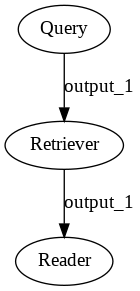

In [ ]:
# You can configure how many candidates the reader and retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers. 
prediction = pipe.run(query="편두통 치료는 어떻게 하나요?", top_k_retriever=30, top_k_reader=5)

04/25/2021 05:49:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.158s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  6.56 Batches/s]


In [ ]:
from haystack.utils import print_answers
print_answers(prediction, details="medium")

[   {   'answer': '수술적 치료',
        'context': ' 이식술은 증상의 심한 정도, 관상동맥의 해부학적 특성, 병변의 특징 및 심장 기능 등을 고려하여 '
                   '결정되는데, 다음과 같은 경우 수술적 치료를 고려할 수 있습니다.\n'
                   '• 좌주간지 병변을 동반한 2- 혹은 3-혈관질환• 증상이 있는 삼중혈관질환 환자\n'
                   '첫째, 혈중 콜레스테롤',
        'score': 20.99239730834961},
    {   'answer': '칼슘 채널 차단제',
        'context': 'lol 등이 있습니다. 말초혈관질환 및 천식, 당뇨환자에는 금기이며 무력감, 우울증과 서맥 저혈압을 '
                   '유발할 수 있습니다. 또한 칼슘 채널 차단제도 편두통 치료에 쓰일 수 있습니다. Flunarizine, '
                   'nimodipine, verapamil 등이 있으며 작용기전을 확',
        'score': 20.534305572509766},
    {   'answer': '예방적 치료',
        'context': ' 아침에 시작하며 구토로 인해 탈수가 되기도 하며 심한 경우에는 탈수로 인해 응급실을 찾기도 합니다. '
                   '이러한 어린이들은 편두통의 예방적 치료로 빈도와 강도를 낮출 수 있습니다.\n'
                   '월경주기와 연관된 편두통은 비월경주기에 발생하는 두통에 비해 통증의 강도가 심하고, 지속시간',
        'score': 18.726787567138672},
    {   'answer': '약물 치료',
        'context': '신분열병)의 치료에도 다양한 방법이 있습니다. 그러나 만일 단 한 가지 치료 방법만을 선택해야 한다면, '
                 

In [ ]:
prediction = pipe.run(query="불면증을 치료하고싶은데 어떡하죠?", top_k_retriever=30, top_k_reader=5)

04/25/2021 06:05:09 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.73 Batches/s]


In [ ]:
print_answers(prediction, details = "medium")

[   {   'answer': '음주',
        'context': '기 전에 술을 마시는데 계속 마셔도 될까요?\n'
                   '알코올의 진정 효과 때문에 잠들기까지 걸리는 시간을 줄일 수 있어 많은 불면증 환자들이 음주를 합니다. '
                   '하지만 음주는 쉽게 잠이 들게 하지만, 잠에서 잘 깨고, 깨어난 후 다시 잠들기 어렵게 합니다. '
                   '지속적으로 음주를 할 경',
        'score': 13.09415054321289},
    {   'answer': '가벼운 산책이나 운동',
        'context': '의 졸음을 유발할 수 있습니다. 이런 악순환이 반복되면 수면 주기가 바뀌게 되어 불면증이 심해질 수 '
                   '있으므로 낮에 졸리더라도 가벼운 산책이나 운동을 하고 낮잠은 자지 않는 것이 좋습니다.\n'
                   '3)집에서 쉽게 실천할 수 있는 불면증 치료 방법에는 어떤 것이 있나요?\n'
                   '침실의 ',
        'score': 5.197921276092529},
    {   'answer': '음주는 피해야 합니다.\n'
                  '잠자리에 들기 전에는 과도한 수분 및 음식 섭취를 하지 않습니다.\n'
                  '잠자리에 들기 전에 과격한 운동은 피하도록 합니다. 잠자리에 들기 직전의 과격한 운동은 잠들기까지의 시간을 '
                  '길게 하므로 피해야 합니다.\n'
                  '침실은 수면을 할 때만 이용합니다. 만약 잠이 오지 않는다면 침실 밖으로 나가도록 합니다.\n'
                  '따뜻한 물 샤워는 수면에 도움을 줍니다. 수면 전 몸을 따뜻하게 할 경우 졸림이 증가하고 깊은 잠을 자는 '
                  '시간이

### **Pipeline (Multiple retriever)**

In [ ]:
from haystack import Pipeline
from haystack.pipeline import JoinDocuments
from haystack.retriever import DensePassageRetriever
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

dpr_retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="voidful/dpr-question_encoder-bert-base-multilingual",
    passage_embedding_model="voidful/dpr-question_encoder-bert-base-multilingual",
    max_seq_len_query=64,
    max_seq_len_passage=256,
    batch_size=16,
    use_gpu=True,
    embed_title=True,
    use_fast_tokenizers=True
)

document_store.update_embeddings(dpr_retriever)

pipe_2 = Pipeline()
pipe_2.add_node(component=es_retriever, name="ESRetriever", inputs=["Query"])
pipe_2.add_node(component=dpr_retriever, name="DPRRetriever", inputs=["Query"])
pipe_2.add_node(component=JoinDocuments(join_mode="concatenate"), name="JoinResults", inputs=["ESRetriever", "DPRRetriever"])
pipe_2.add_node(component=reader, name="QAReader", inputs=["JoinResults"])
pred = pipe_2.run(query="편두통 치료는 어떻게 하나요?", top_k_retriever=1)

04/25/2021 05:51:20 - INFO - filelock -   Lock 139698011963920 acquired on /root/.cache/huggingface/transformers/0515f2ab10def195f5bf001479991759a0e6156d19bcd2620ba9df793b487cf3.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock


04/25/2021 05:51:20 - INFO - filelock -   Lock 139698011963920 released on /root/.cache/huggingface/transformers/0515f2ab10def195f5bf001479991759a0e6156d19bcd2620ba9df793b487cf3.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
04/25/2021 05:51:20 - INFO - filelock -   Lock 139698013803984 acquired on /root/.cache/huggingface/transformers/78176ac1db6b04b6074d9ce8b3dcb6a67e9835b8933e53032a8779d77e31c35d.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24.lock


04/25/2021 05:51:20 - INFO - filelock -   Lock 139698013803984 released on /root/.cache/huggingface/transformers/78176ac1db6b04b6074d9ce8b3dcb6a67e9835b8933e53032a8779d77e31c35d.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24.lock


04/25/2021 05:51:20 - INFO - filelock -   Lock 139700833454544 acquired on /root/.cache/huggingface/transformers/ced7d816ceb9c538744b07f64a56f383543c3c855e39d19e857a60165bad9444.fdcea451c21badcbc8e5a8c25d11436af3243d34cabb506ed2e5f949857a0799.lock


04/25/2021 05:51:20 - INFO - filelock -   Lock 139700833454544 released on /root/.cache/huggingface/transformers/ced7d816ceb9c538744b07f64a56f383543c3c855e39d19e857a60165bad9444.fdcea451c21badcbc8e5a8c25d11436af3243d34cabb506ed2e5f949857a0799.lock


04/25/2021 05:51:21 - INFO - filelock -   Lock 139698011965392 acquired on /root/.cache/huggingface/transformers/e02a57ca8956c42facff67e97125bc124ac2ce42e30d2a3bb2d2d6e3e927c58d.0248427e13413cdd2c81ee923bb7d942905f5e535681ed6c6d3f166d41730978.lock


04/25/2021 05:51:21 - INFO - filelock -   Lock 139698011965392 released on /root/.cache/huggingface/transformers/e02a57ca8956c42facff67e97125bc124ac2ce42e30d2a3bb2d2d6e3e927c58d.0248427e13413cdd2c81ee923bb7d942905f5e535681ed6c6d3f166d41730978.lock
04/25/2021 05:51:21 - INFO - filelock -   Lock 139698012312144 acquired on /root/.cache/huggingface/transformers/a48ef3c88d8da53689c2db15b4860973671675cc7afafab0a35ab9da37c4697d.1d1668fec8e686962952985a6c7ea83a159631a47140ced77de7afc2e676a3cf.lock


04/25/2021 05:51:35 - INFO - filelock -   Lock 139698012312144 released on /root/.cache/huggingface/transformers/a48ef3c88d8da53689c2db15b4860973671675cc7afafab0a35ab9da37c4697d.1d1668fec8e686962952985a6c7ea83a159631a47140ced77de7afc2e676a3cf.lock


Some weights of the model checkpoint at voidful/dpr-question_encoder-bert-base-multilingual were not used when initializing DPRContextEncoder: ['question_encoder.bert_model.embeddings.position_ids', 'question_encoder.bert_model.embeddings.word_embeddings.weight', 'question_encoder.bert_model.embeddings.position_embeddings.weight', 'question_encoder.bert_model.embeddings.token_type_embeddings.weight', 'question_encoder.bert_model.embeddings.LayerNorm.weight', 'question_encoder.bert_model.embeddings.LayerNorm.bias', 'question_encoder.bert_model.encoder.layer.0.attention.self.query.weight', 'question_encoder.bert_model.encoder.layer.0.attention.self.query.bias', 'question_encoder.bert_model.encoder.layer.0.attention.self.key.weight', 'question_encoder.bert_model.encoder.layer.0.attention.self.key.bias', 'question_encoder.bert_model.encoder.layer.0.attention.self.value.weight', 'question_encoder.bert_model.encoder.layer.0.attention.self.value.bias', 'question_encoder.bert_model.encoder.lay

In [ ]:
pipe_2.draw(path="multiple_retriever.png")

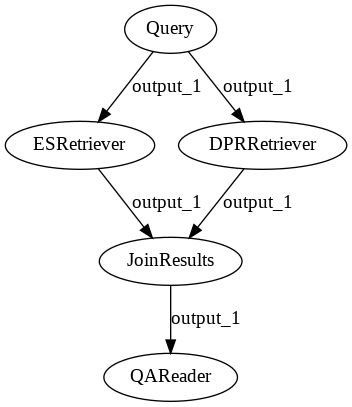

In [ ]:
print_answers(pred, details="medium")

[   {   'answer': '칼슘 채널 차단제',
        'context': 'lol 등이 있습니다. 말초혈관질환 및 천식, 당뇨환자에는 금기이며 무력감, 우울증과 서맥 저혈압을 '
                   '유발할 수 있습니다. 또한 칼슘 채널 차단제도 편두통 치료에 쓰일 수 있습니다. Flunarizine, '
                   'nimodipine, verapamil 등이 있으며 작용기전을 확',
        'score': 20.534305572509766},
    {   'answer': '예방적 치료',
        'context': ' 아침에 시작하며 구토로 인해 탈수가 되기도 하며 심한 경우에는 탈수로 인해 응급실을 찾기도 합니다. '
                   '이러한 어린이들은 편두통의 예방적 치료로 빈도와 강도를 낮출 수 있습니다.\n'
                   '월경주기와 연관된 편두통은 비월경주기에 발생하는 두통에 비해 통증의 강도가 심하고, 지속시간',
        'score': 18.726787567138672},
    {   'answer': '약물치료와 비약물치료',
        'context': '뻣뻣함, 발진, 의식의 이상, 경련, 복시, 근력 약화, 감각 둔화, 어눌한 발음 등이 동반된 경우\n'
                   '편두통의 치료방법은 크게 약물치료와 비약물치료로 나뉩니다. 무엇보다도 두통유발요인을 피하고 두통을 예방할 '
                   '수 있는 올바른 생활습관이 가장 중요합니다.\n'
                   '다양한 약물들이 편',
        'score': 16.141727447509766},
    {   'answer': '공복당장애',
        'context': '8시간 이상 공복하고 검사한 혈당이 100 mg/dl를 넘으면 이미 비정상이고 공복당장애라고 합니다. '
            